In [31]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing import image_dataset_from_directory
import glob
import pandas as pd
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

In [32]:
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
list_path = []
list_labels = []
TRAIN_PATH = "asl_filtered"


for label in labels:
    label_path = os.path.join(TRAIN_PATH, label, "*")
    image_files = glob.glob(label_path)
    
    sign_label = [label] * len(image_files)
    
    list_path.extend(image_files)
    list_labels.extend(sign_label)

metadata = pd.DataFrame({
    "image_path": list_path,
    "label": list_labels
})

metadata

,image_path,label
0,asl_filtered\A\A1.jpg,A
1,asl_filtered\A\A1002.jpg,A
2,asl_filtered\A\A1007.jpg,A
3,asl_filtered\A\A1011.jpg,A
4,asl_filtered\A\A1016.jpg,A
...,...,...
15595,asl_filtered\Z\Z977.jpg,Z
15596,asl_filtered\Z\Z981.jpg,Z
15597,asl_filtered\Z\Z986.jpg,Z
15598,asl_filtered\Z\Z990.jpg,Z


In [33]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    metadata["image_path"], metadata["label"],
    test_size=0.3,
    random_state=2023,
    shuffle=True,
    stratify=metadata["label"]
)

# Create Final DataFrames
data_train = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})

data_val = pd.DataFrame({
    "image_path": X_val,
    "label": y_val
})

In [34]:
label_to_index = {chr(ord('A') + i): i for i in range(26)}  # {'A': 0, 'B': 1, ..., 'Z': 25}

# Apply to your dataframes
data_train['label'] = data_train['label'].map(label_to_index)
data_val['label'] = data_val['label'].map(label_to_index)

In [35]:
data_train.head(10)

,image_path,label
7413,asl_filtered\M\M1958.jpg,12
5892,asl_filtered\J\J512.jpg,9
10184,asl_filtered\Q\Q927.jpg,16
10731,asl_filtered\R\R689.jpg,17
2891,asl_filtered\E\E508.jpg,4
352,asl_filtered\A\A2583.jpg,0
3736,asl_filtered\G\G1610.jpg,6
240,asl_filtered\A\A2079.jpg,0
14908,asl_filtered\Y\Y585.jpg,24
3456,asl_filtered\F\F350.jpg,5


In [37]:
data_val.head(10)

,image_path,label
6828,asl_filtered\L\L2024.jpg,11
9945,asl_filtered\Q\Q2551.jpg,16
5062,asl_filtered\I\I2178.jpg,8
15162,asl_filtered\Z\Z1728.jpg,25
11623,asl_filtered\T\T2001.jpg,19
8726,asl_filtered\O\O2466.jpg,14
4628,asl_filtered\H\H2925.jpg,7
8551,asl_filtered\O\O1679.jpg,14
4822,asl_filtered\I\I1098.jpg,8
5709,asl_filtered\J\J239.jpg,9


In [41]:
train_ds = tf.data.Dataset.from_tensor_slices((data_train['image_path'].values, data_train['label'].values))
val_ds = tf.data.Dataset.from_tensor_slices((data_val['image_path'].values, data_val['label'].values))

In [42]:
IMG_SIZE = (200, 200)

def process_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = image/255.0
    return image, label

In [43]:
BATCH_SIZE = 32
train_ds = train_ds.map(process_image)
train_ds = train_ds.shuffle(buffer_size=1000).batch(BATCH_SIZE)
val_ds = val_ds.map(process_image)
val_ds = val_ds.batch(BATCH_SIZE)

In [44]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


In [45]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

num_classes = data_train['label'].nunique()

base_model = ResNet50(include_top=False, input_shape=(200, 200, 3), weights='imagenet')
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [46]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30
)

Epoch 1/30
342/342 [==============================] - 39s 103ms/step - loss: 6.5738 - accuracy: 0.1560 - val_loss: 4.3839 - val_accuracy: 0.2224
Epoch 2/30
342/342 [==============================] - 32s 94ms/step - loss: 3.9732 - accuracy: 0.2781 - val_loss: 4.0592 - val_accuracy: 0.2393
Epoch 3/30
342/342 [==============================] - 33s 95ms/step - loss: 3.6748 - accuracy: 0.3375 - val_loss: 3.1831 - val_accuracy: 0.4026
Epoch 4/30
342/342 [==============================] - 32s 93ms/step - loss: 3.5827 - accuracy: 0.3659 - val_loss: 4.2214 - val_accuracy: 0.3596
Epoch 5/30
342/342 [==============================] - 32s 93ms/step - loss: 3.3203 - accuracy: 0.4044 - val_loss: 3.7532 - val_accuracy: 0.3361
Epoch 6/30
342/342 [==============================] - 32s 94ms/step - loss: 3.1143 - accuracy: 0.4318 - val_loss: 3.6674 - val_accuracy: 0.4122
Epoch 7/30
342/342 [==============================] - 33s 95ms/step - loss: 3.1346 - accuracy: 0.4476 - val_loss: 3.5607 - val_accuracy

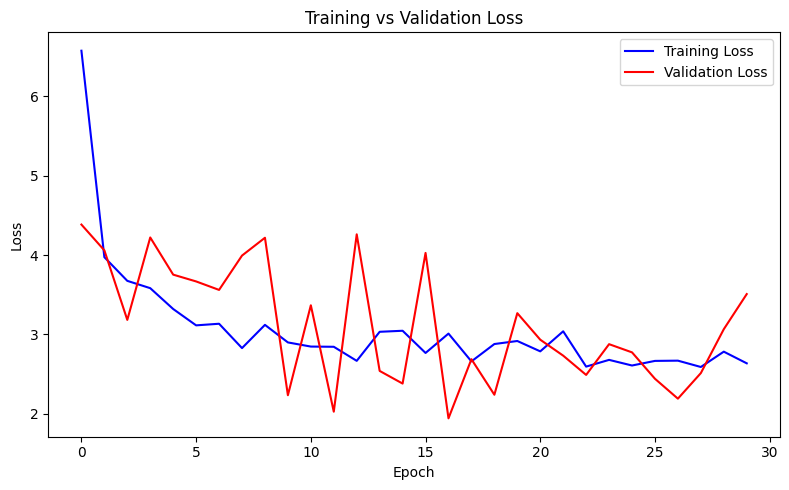

In [47]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = np.arange(30)

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

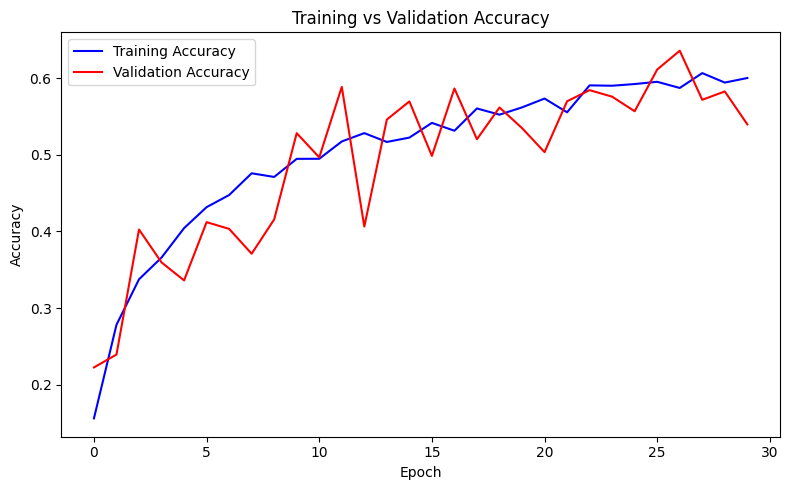

In [48]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()